<a href="https://colab.research.google.com/github/Adrxking/colabs/blob/main/CNN_Flowers_Adrian_Vitys_Vitiene_EJ1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from google.colab import drive
from sklearn. model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import os
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Montamos el Google Drive en el directorio del proyecto y
# descomprimios el fichero con los datos
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -n '/content/drive/MyDrive/Colab Notebooks/flowers/DL_flowers.zip' >> /dev/null

In [ ]:
# Especificamos los paths al directorio que contiene
# las imagenes y al fichero con las etiquetas
data_path = 'flowers/'
imgs_path = data_path + "images/"
labels_path = data_path + "labels.csv"

In [ ]:
# Leemos el fichero CSV con las etiquetas
labels = pd.read_csv(labels_path, dtype = {"class": "category"})

In [ ]:
# Creamos las tres particiones de datos: entrenamiento, validación y test
seed = 0
train_data, test_data = train_test_split(labels, test_size=0.3, random_state=seed)
dev_data, test_data = train_test_split(test_data, test_size=0.5, random_state=seed)

In [ ]:
# Actualizamos los indices de cada particion
train_data = train_data.reset_index(drop=True)
dev_data = dev_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [ ]:
# Preparamos los datos utilizando normalización (rescale)
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Especificamos una serie de parámetros dependientes del conjunto de datos
classes = ["0", "1", "2", "3", "4"]
# clases del problema
n_classes = len(classes)
# numero de clases
img_width = img_height = 224 # dimensiones de la imagen
x_col = 'image_name'
# nombres de las columnas en el fichero CSV
y_col = 'class'

In [ ]:
# Generamos los batches con los datos para las tres particiones
batch_size = 128
# tamaño del batch
train_generator = datagen.flow_from_dataframe(
dataframe=train_data, directory=imgs_path, x_col=x_col, y_col=y_col,
has_ext=True, class_mode="categorical", target_size=(img_width,img_height),
batch_size=batch_size, classes=classes)
dev_generator = datagen.flow_from_dataframe(
dataframe=dev_data, directory=imgs_path, x_col=x_col, y_col=y_col,
has_ext=True, class_mode="categorical", target_size=(img_width, img_height),
batch_size=batch_size, classes=classes)
test_generator = datagen.flow_from_dataframe(
dataframe=test_data, directory=imgs_path, x_col=x_col, y_col=y_col,
has_ext=True, class_mode="categorical", target_size=(img_width,img_height),
batch_size=batch_size, classes=classes)

Found 3020 validated image filenames belonging to 5 classes.
Found 647 validated image filenames belonging to 5 classes.
Found 648 validated image filenames belonging to 5 classes.


In [ ]:
# Cargamos el modelo InceptionV3 pre-entrenado con ImageNet
base_model = tf.keras.applications.InceptionV3(
  weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3)
)

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
# En este ejemplo vamos a ajustar los parámetros de las nuevas capas del modelo,
# dejando fijos los parámetros del resto de capa
# (es decir, que no se actualicen durante el entrenamiento)
for layer in base_model.layers:
  layer.trainable = False
# por defecto, el valor de trainable es True

In [ ]:
# Añadimos nuevas capas al final para adaptar el modelo a nuestro problema
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# Añadimos una última capa completamente conectada con 5 neuronas
# (número de clases) para obtener la salida de la red
predictions = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

In [ ]:
# Creamos el modelo final y lo compilamos
model = tf.keras.models.Model(inputs=[base_model.input], outputs=[predictions])
model.summary()
# representación en modo texto del modelo
model.compile(
  loss='categorical_crossentropy', # función de pérdida para problemas de clasificación multi-clase
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # optimizador Adam, learning rate (1r)
  metrics= ['accuracy'],
  
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
# Entrenamos el modelo con los datos preparados
model.fit(
  train_generator,
  epochs=10,
  verbose=2, # muestra informacion del error al finalizar cada epoch
  steps_per_epoch=len(train_data)/batch_size,
  validation_data=dev_generator,
  validation_steps=len(dev_data)/batch_size,
  use_multiprocessing=True,
  workers=8,  # Número de cores disponibles
  callbacks=[tensorboard_callback]
)

Epoch 1/10
23/23 - 109s - loss: 1.5156 - accuracy: 0.3391 - val_loss: 1.3001 - val_accuracy: 0.5147 - 109s/epoch - 5s/step
Epoch 2/10
23/23 - 84s - loss: 1.2132 - accuracy: 0.5523 - val_loss: 1.0760 - val_accuracy: 0.6182 - 84s/epoch - 4s/step
Epoch 3/10
23/23 - 86s - loss: 1.0193 - accuracy: 0.6430 - val_loss: 0.9456 - val_accuracy: 0.6723 - 86s/epoch - 4s/step
Epoch 4/10
23/23 - 87s - loss: 0.9083 - accuracy: 0.6884 - val_loss: 0.8602 - val_accuracy: 0.7202 - 87s/epoch - 4s/step
Epoch 5/10
23/23 - 85s - loss: 0.8429 - accuracy: 0.7126 - val_loss: 0.8045 - val_accuracy: 0.7434 - 85s/epoch - 4s/step
Epoch 6/10
23/23 - 94s - loss: 0.7789 - accuracy: 0.7377 - val_loss: 0.7548 - val_accuracy: 0.7743 - 94s/epoch - 4s/step
Epoch 7/10
23/23 - 86s - loss: 0.7289 - accuracy: 0.7550 - val_loss: 0.7340 - val_accuracy: 0.7558 - 86s/epoch - 4s/step
Epoch 8/10
23/23 - 92s - loss: 0.6967 - accuracy: 0.7623 - val_loss: 0.6848 - val_accuracy: 0.7821 - 92s/epoch - 4s/step
Epoch 9/10
23/23 - 93s - loss:

In [ ]:
# Por ultimo, podemos evaluar el modelo en el conjunto de test
test_loss, test_acc = model.evaluate(
  test_generator,
  steps=len(test_data)/batch_size,
  verbose=1
)

print("test_loss: %.4f, test_acc: %.4f" % (test_loss, test_acc))

5/5 [==============================] - 10s 2s/step - loss: 0.6553 - accuracy: 0.7778  
test_loss: 0.6553, test_acc: 0.7778


5/5 [==============================] - 12s 2s/step  


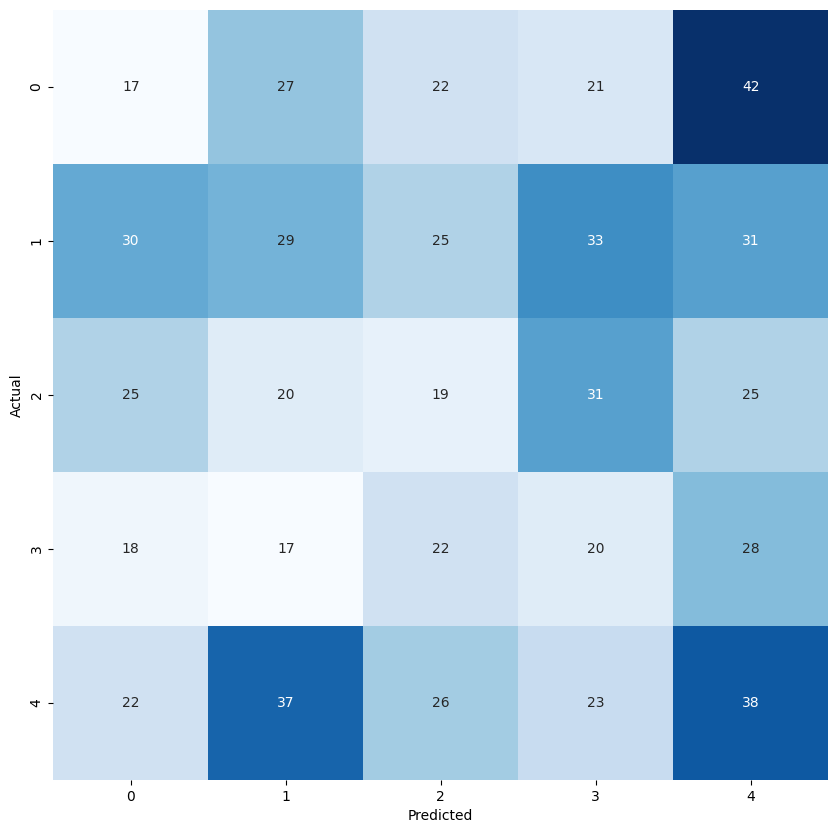

Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.13      0.14       129
           1       0.22      0.20      0.21       148
           2       0.17      0.16      0.16       120
           3       0.16      0.19      0.17       105
           4       0.23      0.26      0.25       146

    accuracy                           0.19       648
   macro avg       0.19      0.19      0.19       648
weighted avg       0.19      0.19      0.19       648



In [ ]:
# Generamos las predicciones en el conjunto de test
y_pred = model.predict(test_generator, steps=len(test_data)/batch_size, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Matriz de confusión
cm = confusion_matrix(test_generator.classes, y_pred_classes)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Reporte de clasificación
print("Classification Report:")
print(classification_report(test_generator.classes, y_pred_classes, target_names=classes))